# NGS Bioinformatics Project
## using the GSE138852 dataset on Alzhimer disease 

Learning Plan for Single-Cell RNA-Seq Analysis
1. Understanding the Fundamentals
Learn the basics of scRNA-seq: What it is, why it's used, and its applications in research.
Study key concepts like gene expression, cell heterogeneity, and sequencing techniques.
Read foundational papers on scRNA-seq (e.g., the original 10x Genomics papers).
2. Data Acquisition and Preparation
Explore sources of public scRNA-seq datasets (GEO, 10x Genomics, Single Cell Portal).
Learn how to download and format datasets for analysis.
3. Computational Tools and Setup
Choose an analysis framework: Seurat (R) or Scanpy (Python).
Set up a bioinformatics environment (Jupyter Notebook for Python, RStudio for R).
Install required packages (e.g., scanpy, Seurat, Bioconductor, anndata).
4. Data Preprocessing
Learn how to filter low-quality cells and genes.
Normalize gene expression data and identify highly variable genes.
Handle batch effects if needed.
5. Dimensionality Reduction & Clustering
Perform Principal Component Analysis (PCA).
Apply clustering algorithms (Louvain, Leiden).
Visualize clusters using t-SNE and UMAP.
6. Biological Interpretation
Identify differentially expressed genes (DEGs).
Annotate cell clusters based on marker genes.
Explore pathways and functional analysis.
7. Advanced Techniques (Optional)
Integrate multiple datasets.
Pseudotime analysis for trajectory inference.
Multi-omics integration (e.g., ATAC-seq + scRNA-seq).


## Dataset Info

applied single-nucleus RNA-seq (snRNA-seq) on the entorhinal cortex from control and AD brains of twelve individuals, yielding a total of 13,214 high quality nuclei. We detail cell-type-specific gene expression patterns, unveiling how transcriptional changes in specific cell subpopulations contribute to AD. We report that the AD risk gene, APOE, is specifically repressed in AD oligodendrocyte progenitor cells and astrocyte subpopulations, and upregulated in an AD-specific microglial subopulation. Integrating transcription factor regulatory modules with AD risk loci revealed drivers of cell-type-specific fate transitions towards AD. For example, transcription factor EB, a master regulator of lysosomal function, regulates multiple disease genes in a specific AD astrocyte sub-population. These results provide insights into the coordinated control of AD risk genes and their cell-type specific contribution to disease susceptibility and are available at http://adsn.ddnetbio.com.

## Install Dependencies

pip install pytorch tensorflow numpy pandas matplotlib scanpy anndata  seaborn leidenalg umap-learn umap scvi-tools

In [1]:
import torch


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used.")
    print("Device name:", torch.cuda.get_device_name(0))
    print("Number of GPUs:", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead.")

# Example of moving a tensor to the GPU
tensor = torch.randn(10, 10).to(device)
print("Tensor is on device:", tensor.device)

GPU is available and being used.
Device name: NVIDIA GeForce GTX 1660 Ti
Number of GPUs: 1
Tensor is on device: cuda:0


In [2]:
#Load dependencies dependencies
import scanpy as sc
import pandas as pd
import numpy as np
import umap
import anndata
import matplotlib
import seaborn
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import scvi

c:\Users\King Keef\anaconda3\envs\ailab\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'scvi'

## Dataset Exploration

Expected structure: The rows should correspond to cells (matching the number of cells in the counts matrix), and the columns should represent different metadata features (such as cell type, batch, condition, etc.).

If the counts matrix has genes × cells, we will need to transpose it when converting to Scanpy (which expects cells × genes).
The metadata should have cells as rows, which should match the number of cells in the counts matrix.

In [2]:
# Define file paths
counts_file = "GSE138852_counts.csv"
metadata_file = "GSE138852_covariates.csv"

# Load gene expression matrix
counts = pd.read_csv(counts_file, index_col=0)

# Load metadata (covariates)
metadata = pd.read_csv(metadata_file, index_col=0)

# Inspect the first few rows of the counts matrix
print(counts.head())

# Check the shape of the counts matrix
print(counts.shape)

# Inspect the first few rows of the metadata
print(metadata.head())

# Check the shape of the metadata
print(metadata.shape)

# Convert to Scanpy's AnnData format
#adata = sc.AnnData(counts.T)  # Transpose so cells are rows and genes are columns
#adata.obs = metadata  # Assign metadata


               AAACCTGGTAGAAAGG_AD5_AD6  AAACCTGGTAGCGATG_AD5_AD6  \
FO538757.2                            0                         0   
AP006222.2                            0                         0   
RP5-857K21.4                          0                         0   
RP11-206L10.9                         0                         0   
NOC2L                                 0                         0   

               AAACCTGTCAGTCAGT_AD5_AD6  AAACCTGTCCAAACAC_AD5_AD6  \
FO538757.2                            0                         0   
AP006222.2                            0                         0   
RP5-857K21.4                          0                         0   
RP11-206L10.9                         0                         0   
NOC2L                                 0                         0   

               AAACCTGTCCAGTATG_AD5_AD6  AAAGCAACATGGGAAC_AD5_AD6  \
FO538757.2                            0                         1   
AP006222.2                      

## Counts Matrix:
The rows of the counts matrix are genes (e.g., FO538757.2, AP006222.2, etc.).
The columns are cells (e.g., AAACCTGGTAGAAAGG_AD5_AD6, AAACCTGGTAGCGATG_AD5_AD6, etc.).
So the counts matrix is indeed genes × cells, which is the opposite of what Scanpy expects.

## Metadata:
The metadata has cells as rows (matching the count of 13214) and 5 metadata columns (e.g., oupSample.batchCond, oupSample.cellType, etc.).

Since the counts matrix is in genes × cells, we need to transpose it so that it becomes cells × genes for Scanpy. Your existing code is correct in this regard:

In [3]:
# Converting and transposing to Scanpy 
adata = sc.AnnData(counts.T)  # Transpose so cells are rows and genes are columns
adata.obs = metadata  # Assign metadata

## Sanity Check

In [4]:
# Check AnnData object again
print(adata)  # Should show 13214 cells × 10850 genes

# Check the first few gene names
print(adata.var_names[:10])  # First 10 gene names

# Check the first few cells with metadata
print(adata.obs.head())  # Should show cell metadata

AnnData object with n_obs × n_vars = 13214 × 10850
    obs: 'oupSample.batchCond', 'oupSample.cellType', 'oupSample.cellType_batchCond', 'oupSample.subclustID', 'oupSample.subclustCond'
Index(['FO538757.2', 'AP006222.2', 'RP5-857K21.4', 'RP11-206L10.9', 'NOC2L',
       'HES4', 'ISG15', 'AGRN', 'C1orf159', 'SDF4'],
      dtype='object')
                         oupSample.batchCond oupSample.cellType  \
AAACCTGGTAGAAAGG_AD5_AD6                  AD              oligo   
AAACCTGGTAGCGATG_AD5_AD6                  AD              oligo   
AAACCTGTCAGTCAGT_AD5_AD6                  AD              oligo   
AAACCTGTCCAAACAC_AD5_AD6                  AD              oligo   
AAACCTGTCCAGTATG_AD5_AD6                  AD              oligo   

                         oupSample.cellType_batchCond oupSample.subclustID  \
AAACCTGGTAGAAAGG_AD5_AD6                     oligo_AD                   o3   
AAACCTGGTAGCGATG_AD5_AD6                     oligo_AD                   o3   
AAACCTGTCAGTCAGT_AD5_AD6 

Understanding the Output
n_obs × n_vars = 13214 × 10850

13214 observations (n_obs) → These are the cells.
10850 variables (n_vars) → These are the genes.
This matches expectations: cells are rows, and genes are columns in the AnnData object.

Metadata (obs):

oupSample.batchCond: Likely represents batch information.
oupSample.cellType: Labels for different cell types.
oupSample.cellType_batchCond: Cell type info adjusted for batch.
oupSample.subclustID: Sub-clustering assignments.
oupSample.subclustCond: Condition-specific sub-clustering.

## Preprocessing Steps for scRNA-Seq Analysis:


### Doublet elimination
Why remove doublets? doublets can be mistaken for intermediate populations or transitory states that do not actually exist. Thus, it is desirable to identify and remove doublet libraries so that they do not compromise interpretation of the results.
problems:
Confound downstream analyses: Doublets can be mistaken for intermediate populations or transitory states. 
Disrupt developmental trajectories: Doublets can interfere with differential expression analysis. 


1. Quality Control
We need to perform quality control (QC) to filter out low-quality cells and genes. these are the QC filters we will use:
    Cells with low gene counts (potentially dead cells).
    Cells with high mitochondrial gene content (potentially stressed or damaged cells).
    Genes with low expression across cells (often considered lowly expressed noise).
    We'll calculate the number of genes per cell and the percentage of mitochondrial genes per cell.

2. Normalization
Normalization ensures that cell-to-cell differences in sequencing depth are accounted for, making the data comparable across cells.

3. Log Transformation
Log transformation makes the data more suitable for downstream analysis, especially clustering and visualization.

4. Visualize the QC Metrics (Optional)
It's helpful to visualize the QC metrics to ensure everything looks good after filtering. This will help you check the distribution of the number of genes and mitochondrial percentage across the cells.
The violin plot will give you a visual representation of the distribution of the number of genes and mitochondrial gene percentage for each cell.

In [5]:
sc.pp.filter_genes(adata, min_cells = 10) #only keep genes found in at least 10 cells
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3') #HVG
print(adata)

AnnData object with n_obs × n_vars = 13214 × 2000
    obs: 'oupSample.batchCond', 'oupSample.cellType', 'oupSample.cellType_batchCond', 'oupSample.subclustID', 'oupSample.subclustCond'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'


In [6]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

df = solo.predict()
df['prediction'] = solo.predict(soft = False)

df.index = df.index.map(lambda x: x[:-2])

df

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\King Keef\Desktop\Relearning Comp Bio\NGS\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [24:51<00:00,  3.53s/it, v_num=1, train_loss_step=459, train_loss_epoch=438]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [24:51<00:00,  3.73s/it, v_num=1, train_loss_step=459, train_loss_epoch=438]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\King Keef\Desktop\Relearning Comp Bio\NGS\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\King Keef\Desktop\Relearning Comp Bio\NGS\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 353/400:  88%|████████▊ | 353/400 [05:59<00:47,  1.02s/it, v_num=1, train_loss_step=0.166, train_loss_epoch=0.185] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.195. Signaling Trainer to stop.


c:\Users\King Keef\Desktop\Relearning Comp Bio\NGS\.venv\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
c:\Users\King Keef\Desktop\Relearning Comp Bio\NGS\.venv\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction
AAACCTGGTAGAAAGG_AD5_A,0.034287,0.965713,singlet
AAACCTGGTAGCGATG_AD5_A,0.327271,0.672729,singlet
AAACCTGTCAGTCAGT_AD5_A,0.473350,0.526650,singlet
AAACCTGTCCAAACAC_AD5_A,0.361865,0.638135,singlet
AAACCTGTCCAGTATG_AD5_A,0.012831,0.987169,singlet
...,...,...,...
TTTGGTTTCCGTACAA_AD1_A,0.000079,0.999921,singlet
TTTGTCACAAGCCATT_AD1_A,0.017722,0.982278,singlet
TTTGTCAGTATAGGTA_AD1_A,0.000624,0.999376,singlet
TTTGTCATCCACTGGG_AD1_A,0.561968,0.438032,doublet


<class 'numpy.ndarray'>


c:\Users\King Keef\Desktop\Relearning Comp Bio\NGS\.venv\lib\site-packages\scanpy\preprocessing\_normalization.py:208: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


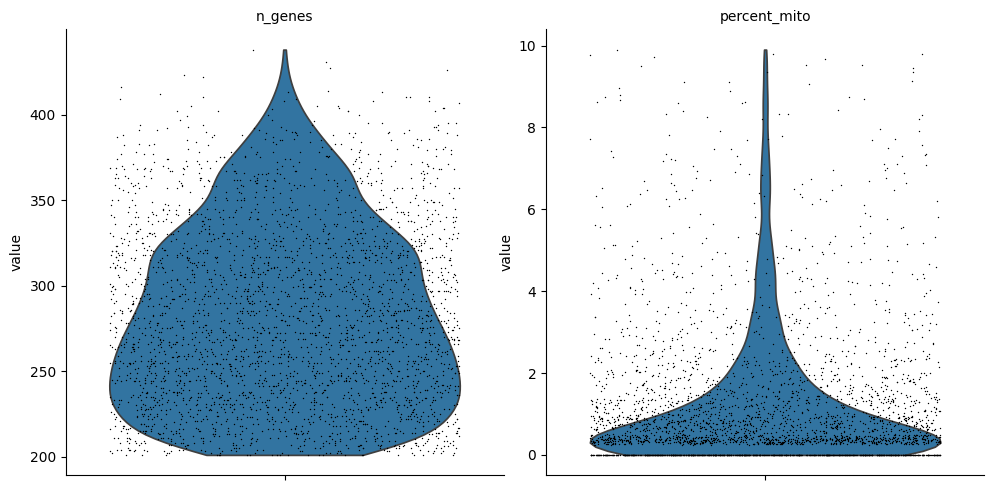

In [ ]:
# Check if the matrix is sparse or dense
print(type(adata.X))  # This should give us an idea of the matrix type (in this instance it is already dense)

# If it's sparse, convert to dense for the operations
#adata_dense = adata.X.toarray() if isinstance(adata.X, scipy.sparse.csr.csr_matrix) else adata.X


# 1. Quality Control: Calculate the number of genes and mitochondrial gene percentage per cell
# Calculate the number of genes expressed in each cell (non-zero entries)
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1) 

# Calculate the percentage of mitochondrial genes
# Assuming mitochondrial genes start with "MT-" (common prefix in human datasets)
mito_genes = [gene for gene in adata.var_names if gene.startswith('MT-')]


# If mito_genes is empty, print a message
if not mito_genes:
    print("No mitochondrial genes found. Check gene name prefixes.")

    
adata.obs['percent_mito'] = adata[:, mito_genes].X.sum(axis=1) / adata.obs['n_genes'] * 100



# 2. Filtering out low-quality cells based on QC metrics
# Filter cells with too many or too few genes, and high mitochondrial content
adata = adata[(adata.obs['n_genes'] > 200) & (adata.obs['n_genes'] < 6000) & (adata.obs['percent_mito'] < 10), :]


# 3. Normalize the data to account for different sequencing depths across cells
sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize each cell to have 10,000 total counts
# Check if the data has already been log-transformed by looking at the minimum value
if np.min(adata.X) > 0:  # If all values are positive, it might be log-transformed
    print("Data appears to be already log-transformed.")
else:
    sc.pp.log1p(adata)  # Log-transform the data if it hasn't been done yet


# 4. Visualize the QC metrics (optional but helpful for exploration)
sc.pl.violin(adata, ['n_genes', 'percent_mito'], jitter=0.4, multi_panel=True)


## Dimensionality Reduction with PCA
Before performing clustering, it's common practice to reduce the dimensionality of the data to a smaller number of components while retaining the most important variation in the data. PCA (Principal Component Analysis) is a common method for this.

We'll:
Perform PCA on the data.
Visualize the results of the first few principal components.

sc.pp.pca: This function performs PCA on the adata object. We will use the top 50 principal components (PCs) in this case to capture the major variation in the dataset.

n_comps=50: This specifies that we want to use the first 50 principal components.
sc.pl.pca_variance_ratio: This will plot the explained variance ratio for each of the top 50 components, showing how much of the total variation is explained by each principal component. A steep curve means the first few components explain most of the variation.
Interpretation:

The explained variance ratio plot tells you how much of the data's variability is captured by each PC. Usually, the first few PCs capture the majority of variation in the dataset which is true in this instance.
After this, you can visualize the first two principal components.

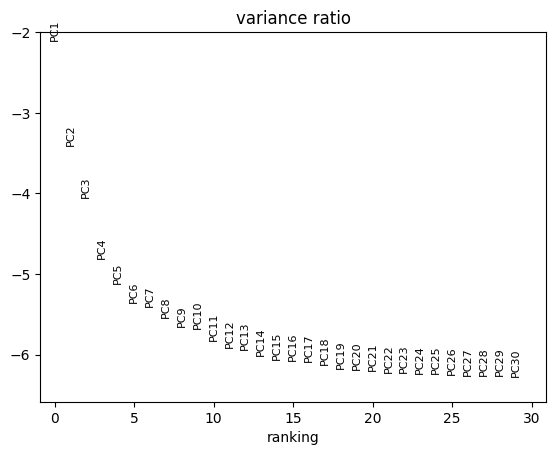

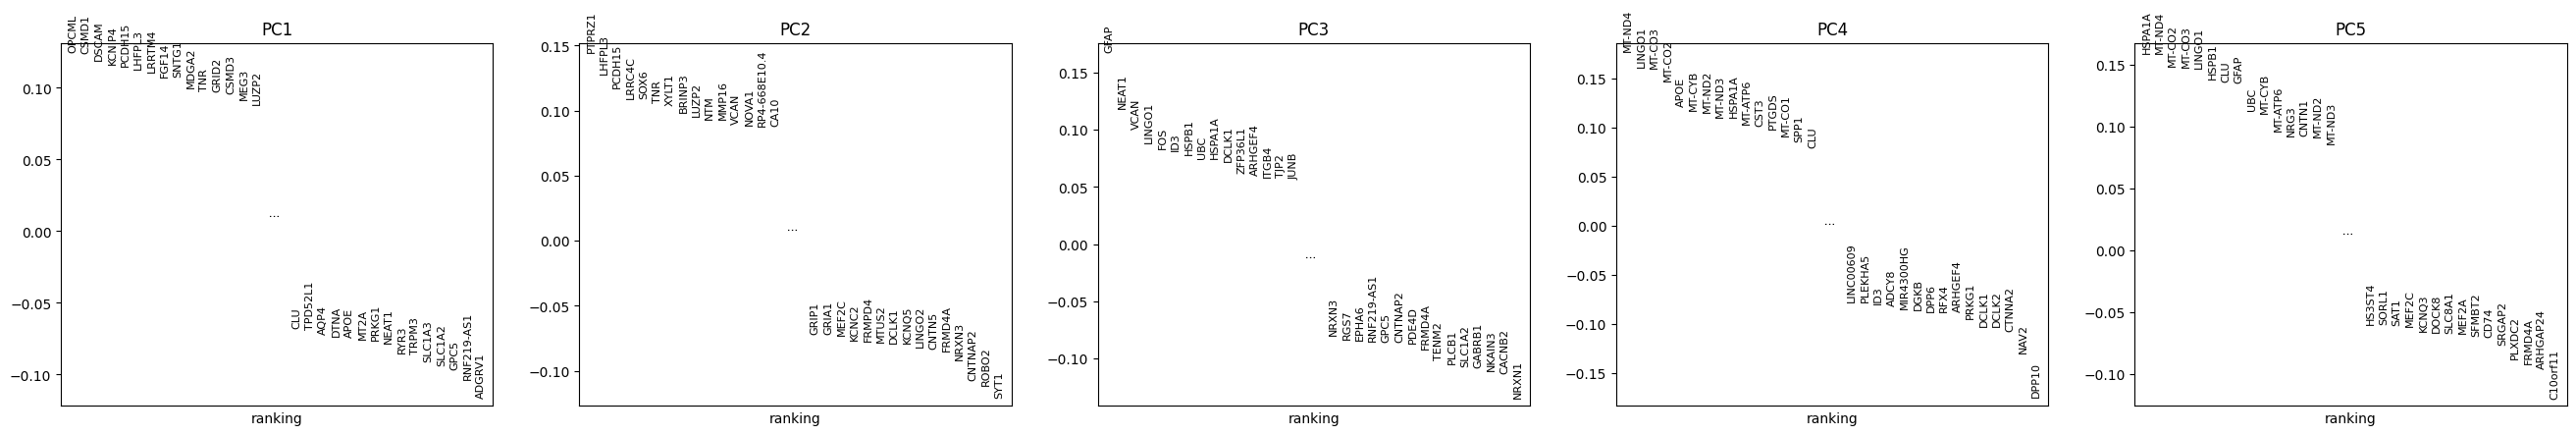

In [18]:
# 5. Perform PCA
sc.pp.pca(adata, n_comps=30)  # We’ll use the top 50 principal components

# Visualize the explained variance ratio for each component
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=30)

# Visualize the first two principal components
#sc.pl.pca(adata, color='oupSample.cellType')  # Color by cell type (adjust accordingly)

sc.pl.pca_loadings(adata, components=[1,2,3,4,5])  # Top genes contributing to PC1 and 2


## Clustering the Cells
Next, we’ll perform clustering on the data to identify groups of cells that share similar expression profiles. We’ll use the Leiden algorithm, which is popular for single-cell RNA-seq data clustering.

Neighborhood computation: First, we compute the neighborhood graph (using PCA or the full expression matrix).
Clustering: Apply the Leiden algorithm to identify clusters of similar cells.

6. sc.pp.neighbors: This function computes a nearest neighbor graph using the PCA embeddings. It's essential to have a neighborhood graph before performing clustering.
    n_neighbors=10: Number of neighbors to consider for each cell when building the graph.
    n_pcs=30: Number of principal components to use for constructing the neighbor graph (in our case, we selected the first 30 PCs for the neighborhood computation).
7. sc.tl.leiden: This performs the Leiden clustering algorithm on the nearest neighbor graph.
    resolution=0.5: The resolution parameter controls the number of clusters. Higher values lead to more clusters, and lower values lead to fewer clusters.
    After running Leiden clustering, you can examine the adata.obs['leiden'] column to see the cluster labels assigned to each cell.

In [24]:
print(adata)

AnnData object with n_obs × n_vars = 3044 × 2000
    obs: 'oupSample.batchCond', 'oupSample.cellType', 'oupSample.cellType_batchCond', 'oupSample.subclustID', 'oupSample.subclustCond', '_scvi_batch', '_scvi_labels', 'n_genes', 'percent_mito', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'log1p', 'pca', 'oupSample.cellType_colors', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


leiden
0    982
1    813
2    497
3    249
4    181
5    134
6     84
7     55
8     49
Name: count, dtype: int64


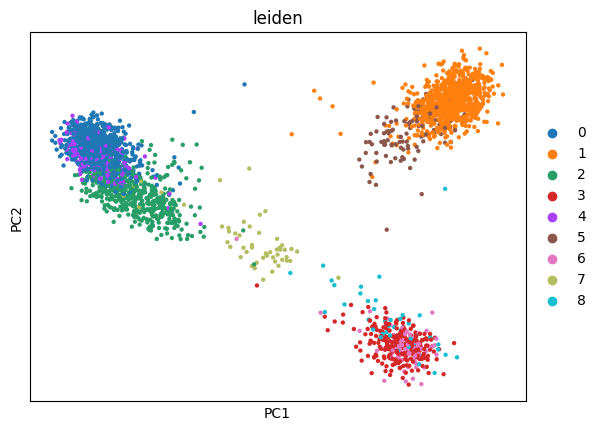

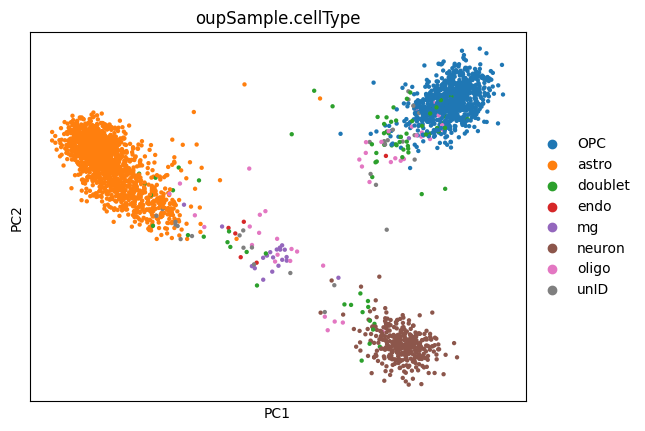

In [33]:
# 6. Compute the nearest neighbor graph using PCA
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30, metric='cosine')  # We’ll use the first 30 PCs

# 7. Perform Leiden clustering
sc.tl.leiden(adata, resolution=0.4)  # You can adjust the resolution parameter for fine-tuning the number of clusters
print(adata.obs['leiden'].value_counts())  # Check how many cells are in each cluster

# Visualize the clusters in PCA space
sc.pl.pca(adata, color='leiden')  # Color cells by their cluster assignment

#key
sc.pl.pca(adata, color='oupSample.cellType')  # Color by cell type (adjust accordingly)


## UMAP for Visualization
After performing clustering, it's helpful to visualize the cells in two dimensions using UMAP (Uniform Manifold Approximation and Projection). UMAP is a non-linear dimensionality reduction technique that is especially good for visualizing high-dimensional data like scRNA-seq.

UMAP computation: Use the previously computed neighborhood graph to compute the UMAP embedding.
Visualization: Create a 2D UMAP plot with cells colored by their cluster labels.

8. sc.tl.umap: This function computes the UMAP embedding for your dataset.
    Visualize the UMAP: Once the UMAP embedding is computed, you can visualize the cells, colored by their Leiden cluster label.

Interpretation:

The UMAP plot will show how cells group together in 2D space. Cells that are close to each other in the UMAP plot have similar gene expression profiles.
Clusters of cells should be visibly separated in the plot. Each cluster will be colored according to the Leiden cluster labels.

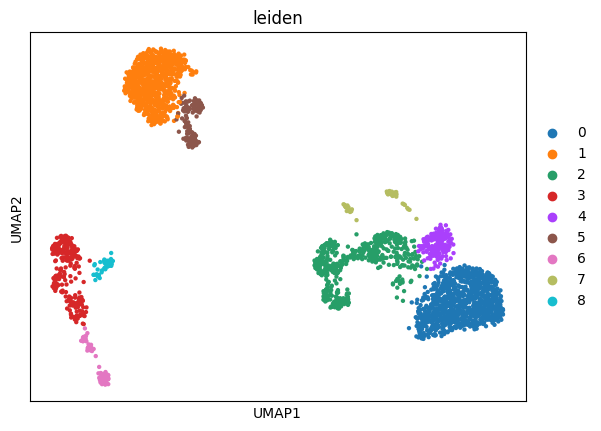

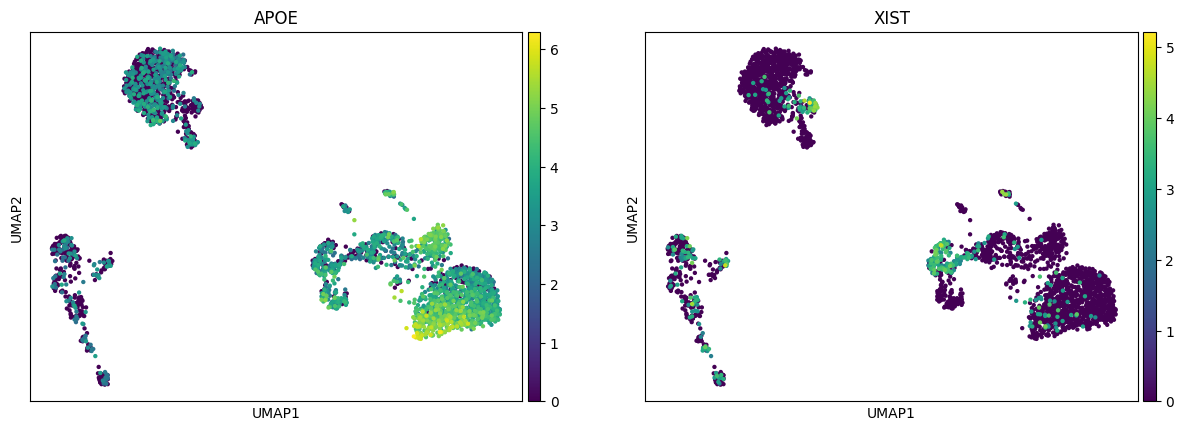

In [34]:
# 8. Compute UMAP
sc.tl.umap(adata)

# Visualize UMAP, coloring by Leiden cluster
sc.pl.umap(adata, color='leiden')

# Example: Visualizing expression of specific genes (change the gene names based on the dataset)
sc.pl.umap(adata, color=['APOE', 'XIST'])  # Replace with relevant genes

## Visualizing Cluster-Specific Markers
To better understand what each cluster represents biologically, you can plot the expression of specific genes that are known markers for certain cell types. For example, you could visualize genes related to neurons, glial cells, or immune cells if available in your dataset.

Find Differentially Expressed Genes
To perform differential expression analysis, you can use scanpy’s rank_genes_groups function, which compares gene expression between clusters. We’ll use the Leiden clustering results as our grouping variable.

c:\Users\King Keef\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


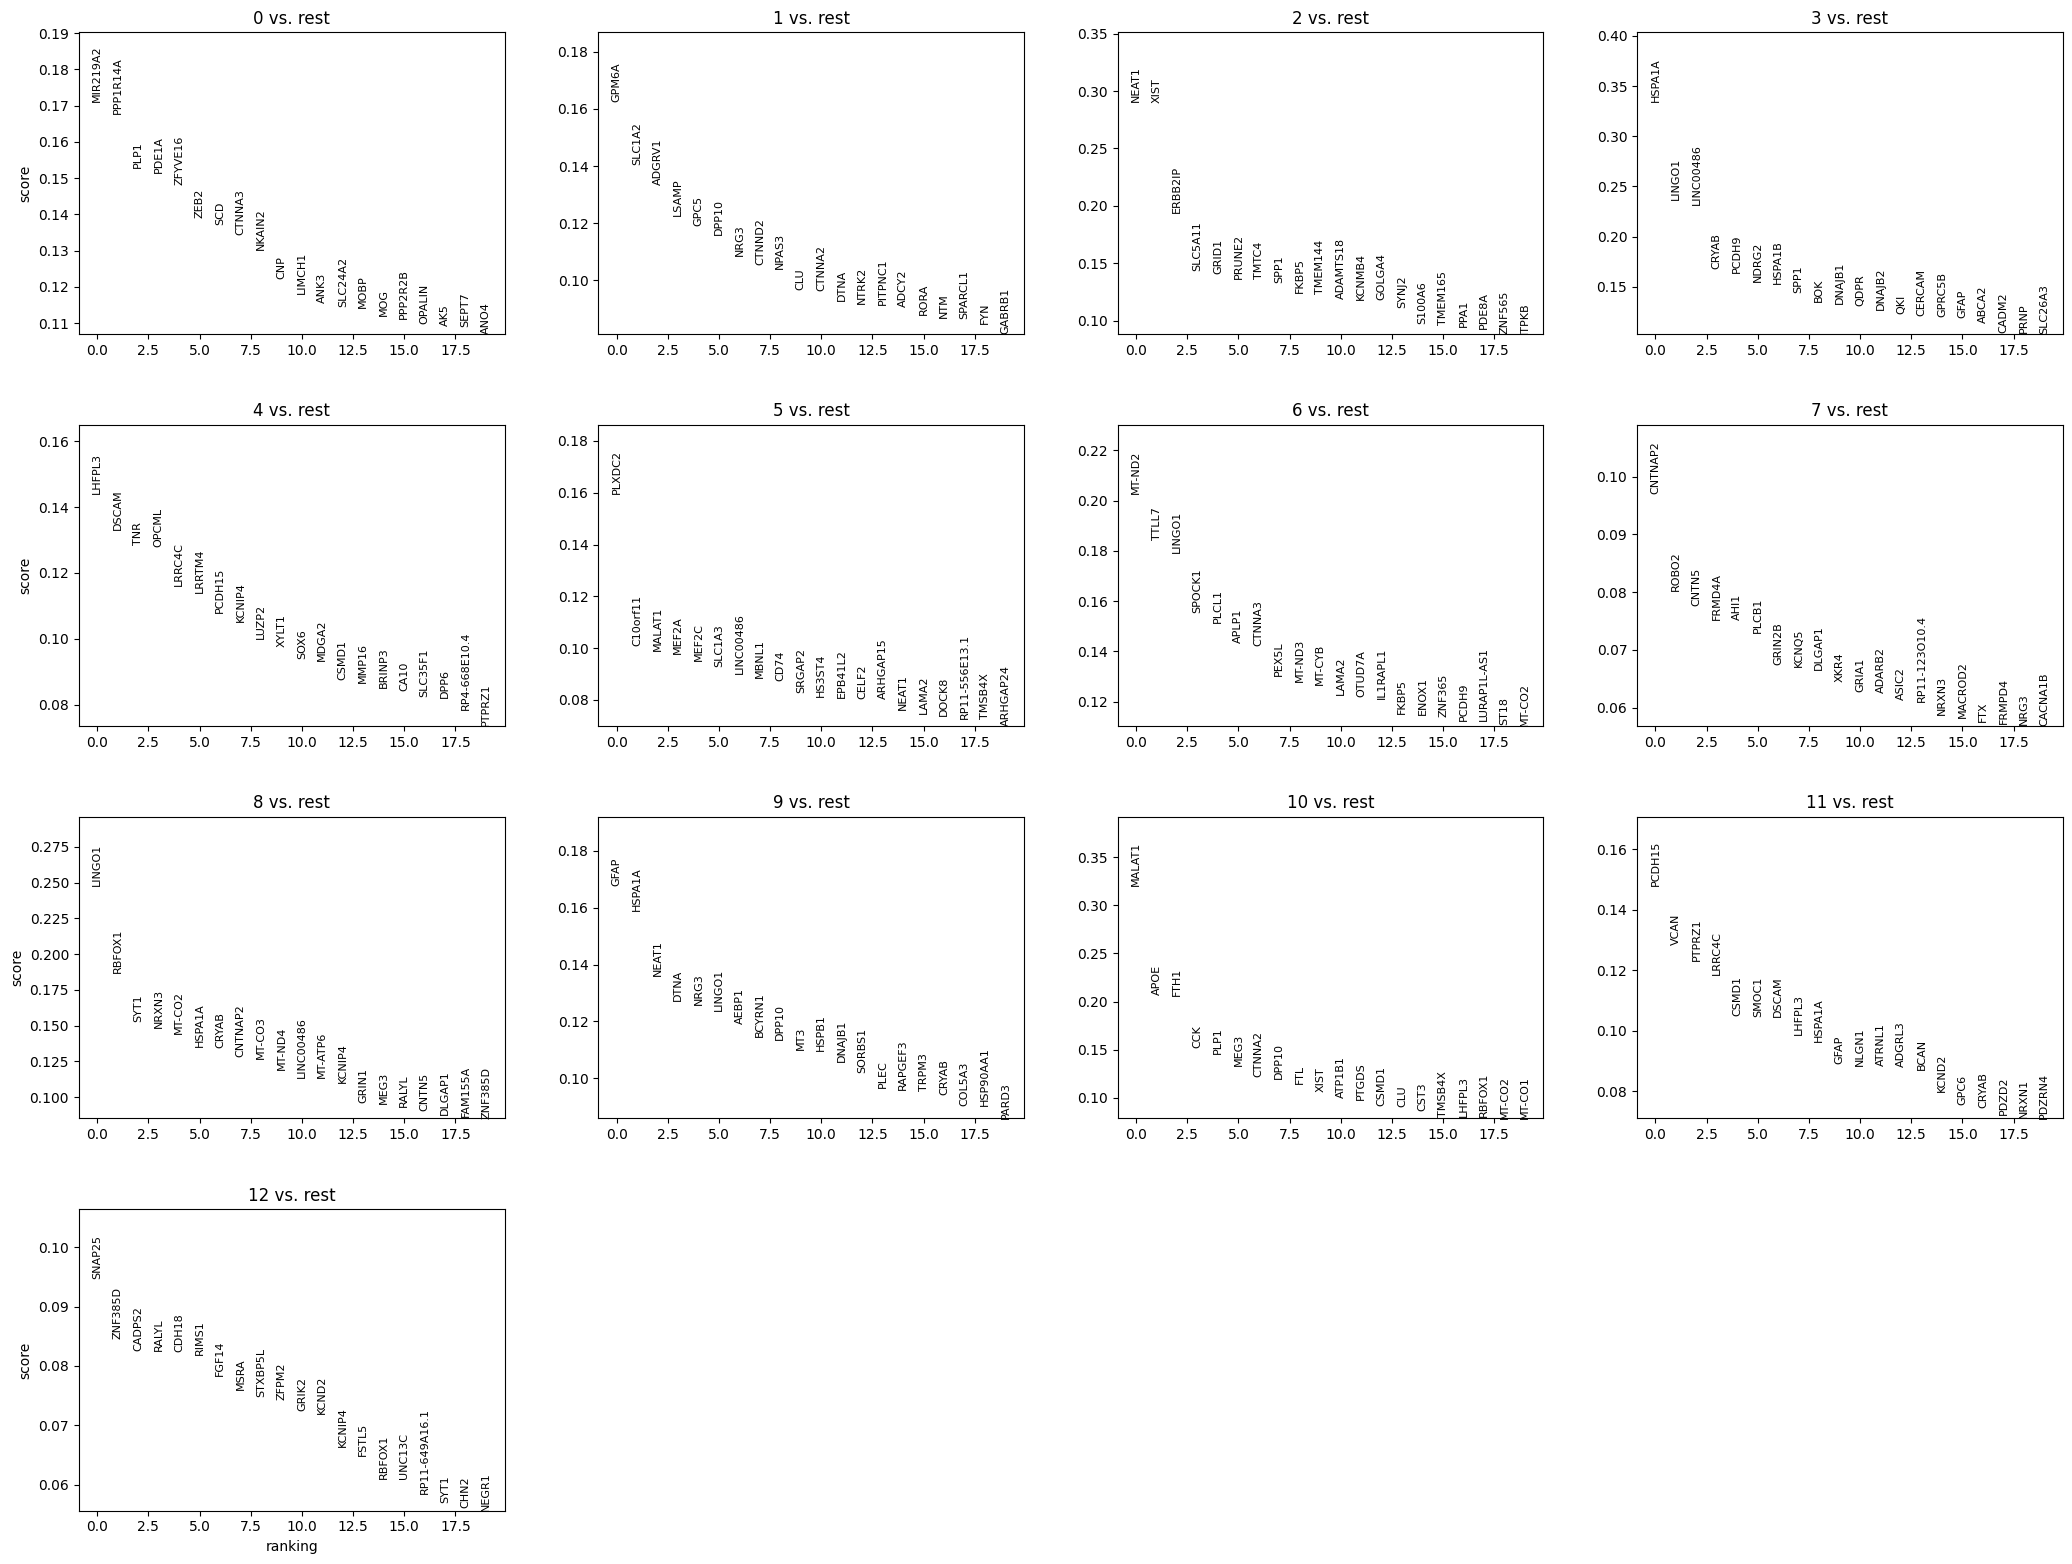

In [110]:
# Perform differential expression analysis for the Leiden clusters
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')  # You can also use 'wilcoxon' or 'logreg'

# Show top 20 differentially expressed genes across clusters
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)


After running differential expression analysis, we can visualize the results using different plots.

Heatmap: To visualize the expression of top differentially expressed genes across clusters.
Violin Plot: To visualize the expression of specific genes across clusters, you can use a violin plot. This is helpful for seeing the distribution of expression for each gene in each cluster.
Dot Plot: A dot plot is another way to visualize gene expression across clusters.

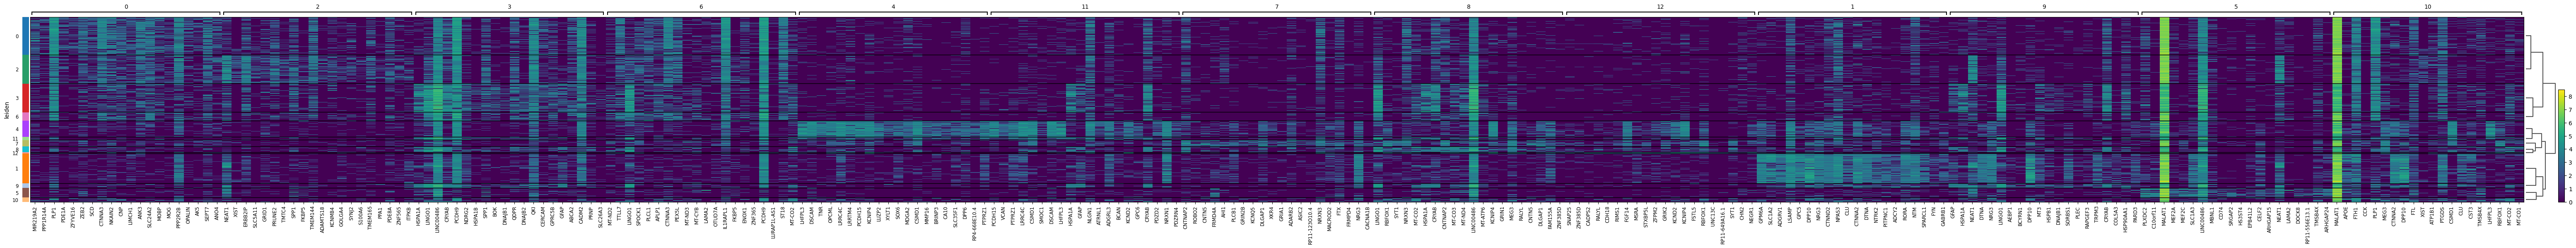

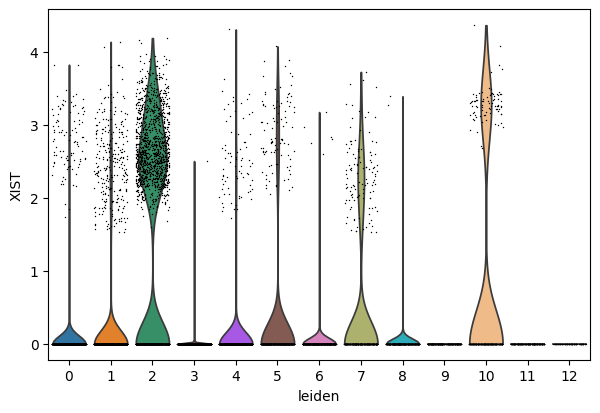

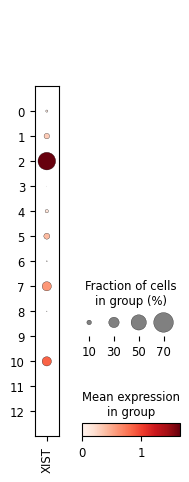

In [111]:
# Plot heatmap of top differentially expressed genes
sc.pl.rank_genes_groups_heatmap(adata, n_genes=20, groupby='leiden', show_gene_labels=True)

# Plot violin plot for the top differentially expressed gene
sc.pl.violin(adata, ['XIST'], groupby='leiden', jitter=0.4)

# Plot a dot plot for the top differentially expressed gene
sc.pl.dotplot(adata, ['XIST'], groupby='leiden')


##  Clustering Validation: Silhouette Analysis and Adjusted Rand Index
Clustering validation is essential to assess the quality of your clustering results. In this case, we’ll explore two methods:

Silhouette Analysis: Measures how similar each cell is to its own cluster compared to other clusters. It produces a score between -1 and 1, where a score closer to 1 indicates that the cell is well-clustered.

Adjusted Rand Index (ARI): A metric that measures the similarity between two clusterings (e.g., comparing your clustering with ground truth or known labels). The ARI score ranges from -1 to 1, where 1 means perfect agreement, 0 means random clustering, and negative values suggest worse than random clustering.

1. Silhouette Analysis
Why It’s Useful:
Silhouette score tells you how well each cell fits into its assigned cluster.
The score ranges from -1 to 1:
1: The cell is well-matched to its own cluster and poorly matched to neighboring clusters.
0: The cell is on or very close to the boundary between clusters.
-1: The cell is incorrectly clustered and more similar to a neighboring cluster.

In [112]:
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Get the cell cluster assignments (e.g., 'leiden' labels)
cluster_labels = adata.obs['leiden'].astype(int)

# Calculate the pairwise distance matrix between cells
# You can use the PCA or the latent space embeddings for clustering
# We'll use PCA embeddings for this example
X = adata.obsm['X_pca']  # You can replace this with 'X_scVI' for scVI embeddings

# Compute the Silhouette Score
sil_score = silhouette_score(X, cluster_labels, metric='euclidean')
print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.2671809792518616


2. Adjusted Rand Index (ARI)
Why It’s Useful:
ARI compares your clustering results with a ground truth clustering (e.g., known cell type labels or other clustering assignments).
The ARI score takes into account both the number of pairs of cells that are correctly clustered together and the pairs that are incorrectly grouped.
Step-by-Step:
Obtain the Ground Truth (e.g., labels):
we can compare your clustering results (e.g., Leiden clusters) to our known metadata. 
Based on our metadata columns, we should focus on using the oupSample.cellType or oupSample.subclustID as our ground truth labels for clustering validation, depending on what level of granularity you want for our analysis.

In [113]:
from sklearn.metrics import adjusted_rand_score

# Get the ground truth labels from the metadata (cell type labels)
ground_truth = adata.obs['oupSample.subclustID']

# Get the predicted labels from the clustering (e.g., Leiden clustering)
predicted_labels = adata.obs['leiden']

# Compute Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(ground_truth, predicted_labels)

print(f"Adjusted Rand Index (ARI) Score: {ari_score}")


#ARI based on other labels
from sklearn.metrics import adjusted_rand_score

for col in ['oupSample.cellType', 'oupSample.subclustID', 'oupSample.subclustCond', 'leiden']:
    ari = adjusted_rand_score(adata.obs[col], adata.obs['leiden'])
    print(f"ARI with {col}: {ari:.3f}")



Adjusted Rand Index (ARI) Score: 0.669554496811015
ARI with oupSample.cellType: 0.384
ARI with oupSample.subclustID: 0.670
ARI with oupSample.subclustCond: 0.237
ARI with leiden: 1.000
